In [112]:
#1) take one specific function
#2) Optimize it using gradient descent (and SGD)
#3) Optimize using GA
#4) Optimize using our proposal
#5) Think about the grid thing and be more skeptical on this implementations
#6) Should I use the function itself or the samples from it - (Initially probably the function alone is fine)
#7) Perhaps the extra could be just using gaussian distributions 

In [113]:
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

Base parameters

In [114]:
limits = 10

# Define the search space for parameters a and b
a_values = np.linspace(-limits, limits, 100)  
b_values = np.linspace(-limits, limits, 100)

# Compute raw error and MSE over the (a, b) grid
error_grid = np.zeros((len(a_values), len(b_values)))
MSE_grid = np.zeros((len(a_values), len(b_values)))

# Generate equally spaced sample points in 1D for function evaluation
num_points = 100  
x_range_1D = np.linspace(-5, 5, num_points)

# Small constant to avoid log(0)
epsilon = 1e-6 

# Define Zero Threshold
manual_thresholds = {
    "Raw Error": 0.1,
    "MSE": 0.1,
}

# Define the true parameters for the Linear function
true_a, true_b = 5, 4

In [115]:
# Define function
def linear_model(x, a, b):
    x = np.array(x)
    return a * np.sum(x) + b * a -b**2*a + a**3 - b

# Define the target function using the true parameters
def target_function(x):
    return linear_model(x, true_a, true_b)

def found_function(x, a, b):
    return linear_model(x, a, b)

In [116]:
# Functions to find local and global minima
def find_local_minima(grid, a_vals, b_vals):
    local_min_mask = grid == scipy.ndimage.minimum_filter(grid, size=3)
    return [(a_vals[i], b_vals[j]) for i, j in np.argwhere(local_min_mask)]

def find_global_minimum(grid, a_vals, b_vals):
    min_index = np.unravel_index(np.argmin(grid), grid.shape)
    return (a_vals[min_index[0]], b_vals[min_index[1]])

Generate landscape

In [117]:
def create_landscape(x_range_1D, true_a, true_b, a_values, b_values, model, epsilon):
    true_values_1D = np.array([model([x], true_a, true_b) for x in x_range_1D])

    # Compute raw error and MSE over the (a, b) grid
    error_grid = np.zeros((len(a_values), len(b_values)))
    MSE_grid = np.zeros((len(a_values), len(b_values)))

    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            predicted_values = np.array([model([x], a, b) for x in x_range_1D])
            error_grid[i, j] = np.mean(true_values_1D - predicted_values)  
            MSE_grid[i, j] = np.mean((true_values_1D - predicted_values) ** 2)  

    error_grid_log = np.sign(error_grid) * np.log1p(np.abs(error_grid) + epsilon)
    MSE_grid_log = np.log1p(MSE_grid + epsilon)
    
    return true_values_1D, error_grid, MSE_grid, error_grid_log, MSE_grid_log

In [118]:
true_values_1D, error_grid, MSE_grid, error_grid_log, MSE_grid_log = create_landscape(x_range_1D, true_a, true_b, a_values, b_values, linear_model, epsilon)

Proposed model

In [119]:
# Function to sample two points ensuring one is positive and the other is negative in raw error
def sample_valid_pairs(error_grid, a_vals, b_vals, max_tries=10000):
    tries = 0  # Initialize attempt counter

    while tries < max_tries:
        tries += 1

        # Randomly sample two pairs of (a, b) values
        sampled_pair_1 = (random.choice(a_vals), random.choice(b_vals))
        sampled_pair_2 = (random.choice(a_vals), random.choice(b_vals))

        # Get their corresponding error values
        idx1 = (np.abs(a_vals - sampled_pair_1[0])).argmin(), (np.abs(b_vals - sampled_pair_1[1])).argmin()
        idx2 = (np.abs(a_vals - sampled_pair_2[0])).argmin(), (np.abs(b_vals - sampled_pair_2[1])).argmin()

        error_1 = error_grid[idx1]
        error_2 = error_grid[idx2]

        # Ensure one error is positive and the other is negative
        if error_1 * error_2 < 0:
            return sampled_pair_1, sampled_pair_2

    # Raise an error if no valid pairs are found within max_tries
    raise ValueError(f"Failed to find valid pairs after {max_tries} attempts.")

In [120]:
def bisection_method(error_grid, a_vals, b_vals, sampled_pair_1, sampled_pair_2, tol=1e-3, max_iter=50):
    # Get the initial sampled points
    (a_low, b_low), (a_high, b_high) = sampled_pair_1, sampled_pair_2

    for _ in range(max_iter):
        # Compute midpoint
        a_mid = (a_low + a_high) / 2
        b_mid = (b_low + b_high) / 2

        # Get error at midpoint
        idx_mid = (np.abs(a_vals - a_mid)).argmin(), (np.abs(b_vals - b_mid)).argmin()
        error_mid = error_grid[idx_mid]

        # If error is sufficiently close to zero, stop
        if abs(error_mid) < tol:
            return a_mid, b_mid

        # Update bounds based on sign of error
        idx_low = (np.abs(a_vals - a_low)).argmin(), (np.abs(b_vals - b_low)).argmin()
        error_low = error_grid[idx_low]

        if error_mid * error_low < 0:  # Zero crossing lies between (a_low, b_low) and (a_mid, b_mid)
            a_high, b_high = a_mid, b_mid
        else:  # Zero crossing lies between (a_mid, b_mid) and (a_high, b_high)
            a_low, b_low = a_mid, b_mid

    return a_mid, b_mid  # Return the best approximation

In [121]:
# Random walk to find the minimum MSE from the estimated zero-error region with tolerance
def random_walk_mse_with_path(a_start, b_start, mse_grid, error_grid, a_vals, b_vals, step_size=1, max_iter=10000, tol=10):
    a_current, b_current = a_start, b_start
    path = [(a_current, b_current)]  # Store path

    for _ in range(max_iter):
        idx_a = (np.abs(a_vals - a_current)).argmin()
        idx_b = (np.abs(b_vals - b_current)).argmin()
        mse_current = mse_grid[idx_a, idx_b]

        step_a = random.uniform(-step_size, step_size)
        step_b = random.uniform(-step_size, step_size)

        a_new, b_new = a_current + step_a, b_current + step_b
        a_new = np.clip(a_new, a_vals[0], a_vals[-1])
        b_new = np.clip(b_new, b_vals[0], b_vals[-1])

        idx_a_new = (np.abs(a_vals - a_new)).argmin()
        idx_b_new = (np.abs(b_vals - b_new)).argmin()
        mse_new = mse_grid[idx_a_new, idx_b_new]
        error_new = error_grid[idx_a_new, idx_b_new]

        # Only move if the new point has raw error within tolerance and a lower MSE
        if abs(error_new) < tol and mse_new < mse_current:
            a_current, b_current = a_new, b_new
            mse_current = mse_new
            path.append((a_current, b_current))  # Store path

    return a_current, b_current, path, mse_new


In [122]:
#The output must provide final position - OK, path, and values assossiated with raw error, mse, and grad

In [123]:
"""
def proposed_optimizer(error_grid, a_values, b_values, MSE_grid):
    sampled_pair_1, sampled_pair_2 = sample_valid_pairs(error_grid, a_values, b_values)
    a_zero, b_zero = bisection_method(error_grid, a_values, b_values, sampled_pair_1, sampled_pair_2)
    a_mse_min, b_mse_min, mse_path, mse_new = random_walk_mse_with_path(a_zero, b_zero, MSE_grid, error_grid, a_values, b_values)
    return a_mse_min, b_mse_min, mse_path
"""

'\ndef proposed_optimizer(error_grid, a_values, b_values, MSE_grid):\n    sampled_pair_1, sampled_pair_2 = sample_valid_pairs(error_grid, a_values, b_values)\n    a_zero, b_zero = bisection_method(error_grid, a_values, b_values, sampled_pair_1, sampled_pair_2)\n    a_mse_min, b_mse_min, mse_path, mse_new = random_walk_mse_with_path(a_zero, b_zero, MSE_grid, error_grid, a_values, b_values)\n    return a_mse_min, b_mse_min, mse_path\n'

In [124]:
def proposed_optimizer(error_grid, a_values, b_values, MSE_grid, mse_tol=1e-3, max_iter=10):
    mse_current = 1000000
    a_mse_current = 0
    b_mse_current = 0
    for iteration in range(max_iter):
        sampled_pair_1, sampled_pair_2 = sample_valid_pairs(error_grid, a_values, b_values)
        a_zero, b_zero = bisection_method(error_grid, a_values, b_values, sampled_pair_1, sampled_pair_2)
        a_mse_min, b_mse_min, mse_path, mse_new = random_walk_mse_with_path(a_zero, b_zero, MSE_grid, error_grid, a_values, b_values)
        
        if mse_current > mse_new:
            mse_current = mse_new
            a_mse_current, b_mse_current = a_mse_min, b_mse_min
            
        if abs(mse_new) < mse_tol:
            print(f"Converged in {iteration + 1} iterations with MSE {mse_new}")
            break

    return a_mse_current, b_mse_current, mse_path


Gradient model

In [125]:
def gradient_descent_optimizer(mse_grid, a_vals, b_vals, learning_rate=0.0001, max_iter=100000, tol=1e-12):
    # Randomly sample two pairs of (a, b) values
    sample = (random.choice(a_vals), random.choice(b_vals))
    
    a_current, b_current = sample
    path = [(a_current, b_current)]
    
    epsilon_a = a_vals[1] - a_vals[0]
    epsilon_b = b_vals[1] - b_vals[0]

    for _ in range(max_iter):
        idx_a = (np.abs(a_vals - a_current)).argmin()
        idx_b = (np.abs(b_vals - b_current)).argmin()
        mse_current = mse_grid[idx_a, idx_b]

        a_step = a_current + epsilon_a if a_current + epsilon_a <= a_vals[-1] else a_current
        b_step = b_current + epsilon_b if b_current + epsilon_b <= b_vals[-1] else b_current

        idx_a_step = (np.abs(a_vals - a_step)).argmin()
        idx_b_step = (np.abs(b_vals - b_step)).argmin()

        grad_a = (mse_grid[idx_a_step, idx_b] - mse_current) / epsilon_a
        grad_b = (mse_grid[idx_a, idx_b_step] - mse_current) / epsilon_b
        
        a_new = a_current - learning_rate * grad_a
        b_new = b_current - learning_rate * grad_b

        a_new = np.clip(a_new, a_vals[0], a_vals[-1])
        b_new = np.clip(b_new, b_vals[0], b_vals[-1])

        if np.abs(a_new - a_current) < tol and np.abs(b_new - b_current) < tol:
            break

        a_current, b_current = a_new, b_new
        path.append((a_current, b_current))

    return a_current, b_current, path

GA model

In [126]:
# Updated Genetic Algorithm using mse_grid for fitness evaluation
def genetic_algorithm_mse_grid(mse_grid, a_vals, b_vals, pop_size=50, generations=100, mutation_rate=0.1):
    # Initialize random population of (a, b) pairs using discrete sampling
    population = np.array([[random.choice(a_vals), random.choice(b_vals)] for _ in range(pop_size)])
    history = []

    for gen in range(generations):
        # Evaluate fitness directly from mse_grid
        fitness = []
        for a, b in population:
            idx_a = (np.abs(a_vals - a)).argmin()
            idx_b = (np.abs(b_vals - b)).argmin()
            fitness.append(mse_grid[idx_a, idx_b])
        fitness = np.array(fitness)

        # Store best solution of this generation
        history.append(population[np.argmin(fitness)])

        # Selection: Select the top 50% individuals
        sorted_indices = np.argsort(fitness)
        survivors = population[sorted_indices[:pop_size // 2]]

        # Crossover: Create offspring
        offspring = []
        for _ in range(pop_size // 2):
            parents = survivors[np.random.choice(len(survivors), 2, replace=False)]
            crossover_point = np.random.randint(1, 2)
            child = np.concatenate([parents[0][:crossover_point], parents[1][crossover_point:]])
            offspring.append(child)

        offspring = np.array(offspring)

        # Mutation: Apply random changes using discrete sampling
        for i in range(len(offspring)):
            if np.random.rand() < mutation_rate:
                offspring[i][0] = random.choice(a_vals)
            if np.random.rand() < mutation_rate:
                offspring[i][1] = random.choice(b_vals)

        # New population
        population = np.vstack((survivors, offspring))

    # Final evaluation
    final_fitness = []
    for a, b in population:
        idx_a = (np.abs(a_vals - a)).argmin()
        idx_b = (np.abs(b_vals - b)).argmin()
        final_fitness.append(mse_grid[idx_a, idx_b])
    final_fitness = np.array(final_fitness)

    best_index = np.argmin(final_fitness)
    best_a, best_b = population[best_index]

    return best_a, best_b, np.array(history)


Structure

In [127]:
# Run all three optimizers
a_proposed_min, b_proposed_min, proposed_path = proposed_optimizer(error_grid, a_values, b_values, MSE_grid)
a_gd_min, b_gd_min, gd_path = gradient_descent_optimizer(MSE_grid, a_values, b_values)
a_ga_min, b_ga_min, ga_history = genetic_algorithm_mse_grid(MSE_grid, a_values, b_values)

# Generate function values for all found functions
found_values_proposed = np.array([linear_model(x, a_proposed_min, b_proposed_min) for x in x_range_1D])
found_values_gd = np.array([linear_model(x, a_gd_min, b_gd_min) for x in x_range_1D])
found_values_ga = np.array([linear_model(x, a_ga_min, b_ga_min) for x in x_range_1D])

In [128]:
# Calculate MSE for each optimization method using their found parameters
def calculate_loss(a, b):
    predicted_values = np.array([linear_model(x, a, b) for x in x_range_1D])
    return np.mean((true_values_1D - predicted_values) ** 2)

# Compute MSE for each optimizer
mse_proposed = calculate_loss(a_proposed_min, b_proposed_min)
mse_gd = calculate_loss(a_gd_min, b_gd_min)
mse_ga = calculate_loss(a_ga_min, b_ga_min)

In [129]:
print("mse_proposed: " + str(mse_proposed))
print("mse_gd: " + str(mse_gd))
print("mse_ga: " + str(mse_ga))

mse_proposed: 2.917430592599238
mse_gd: 18.287461201686554
mse_ga: 27.004442274669163


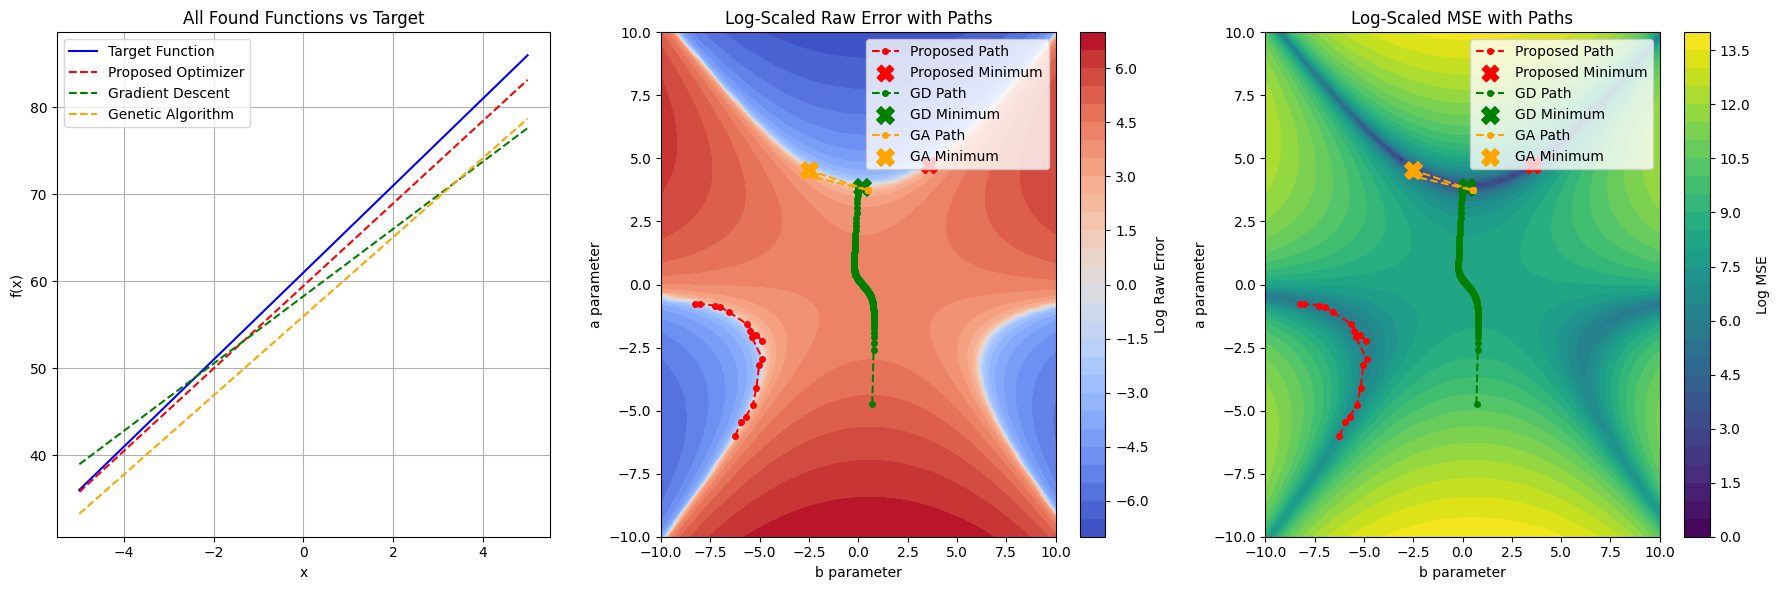

In [130]:
# Plotting results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot all functions together
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
axs[0].plot(x_range_1D, found_values_proposed, color='red', linestyle='--', label="Proposed Optimizer")
axs[0].plot(x_range_1D, found_values_gd, color='green', linestyle='--', label="Gradient Descent")
axs[0].plot(x_range_1D, found_values_ga, color='orange', linestyle='--', label="Genetic Algorithm")
axs[0].set_title("All Found Functions vs Target")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Raw error contour plot with paths and minima
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")

# Proposed Optimizer
proposed_path_array = np.array(proposed_path)
axs[1].plot(proposed_path_array[:, 1], proposed_path_array[:, 0], color="red", linestyle="--", marker="o", markersize=4, label="Proposed Path")
axs[1].scatter(b_proposed_min, a_proposed_min, color="red", marker="X", s=140, label="Proposed Minimum")

# Gradient Descent
gd_path_array = np.array(gd_path)
axs[1].plot(gd_path_array[:, 1], gd_path_array[:, 0], color="green", linestyle="--", marker="o", markersize=4, label="GD Path")
axs[1].scatter(b_gd_min, a_gd_min, color="green", marker="X", s=160, label="GD Minimum")

# Genetic Algorithm
ga_path_array = np.array(ga_history)
axs[1].plot(ga_path_array[:, 1], ga_path_array[:, 0], color="orange", linestyle="--", marker="o", markersize=4, label="GA Path")
axs[1].scatter(b_ga_min, a_ga_min, color="orange", marker="X", s=160, label="GA Minimum")

axs[1].set_title("Log-Scaled Raw Error with Paths")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

# MSE contour plot with paths and minima
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

# Proposed Optimizer Path
axs[2].plot(proposed_path_array[:, 1], proposed_path_array[:, 0], color="red", linestyle="--", marker="o", markersize=4, label="Proposed Path")
axs[2].scatter(b_proposed_min, a_proposed_min, color="red", marker="X", s=140, label="Proposed Minimum")

# Gradient Descent Path
axs[2].plot(gd_path_array[:, 1], gd_path_array[:, 0], color="green", linestyle="--", marker="o", markersize=4, label="GD Path")
axs[2].scatter(b_gd_min, a_gd_min, color="green", marker="X", s=160, label="GD Minimum")

# Genetic Algorithm Path
axs[2].plot(ga_path_array[:, 1], ga_path_array[:, 0], color="orange", linestyle="--", marker="o", markersize=4, label="GA Path")
axs[2].scatter(b_ga_min, a_ga_min, color="orange", marker="X", s=160, label="GA Minimum")

axs[2].set_title("Log-Scaled MSE with Paths")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()

Increasing number of sample

In [131]:
#1) Make a simple database with n points and go on making it bigger to see how much the optimal value change - No need to optimize, only the the numeric result

Compare

In [132]:
#Plot one - target function and the ones found by the optimizers
#Plot two - Raw error, initial position, final position and path of each algorithm
def plot_optimization_path():
    pass

In [133]:
def create_result_table():
    pass